
# Лабораторная работа 7: Определение тональности текста



1. Использовать в классификации внешний словарь тональностей.
2. Улучшить качество базовой предсказательной модели на тестовой выборке за счет добавления и модификации признаков.
3. Сравнить качество классификации на леммах и подтокенах.
4. Обучить fasttext-классификатор, сравнить качество классификации с предобученными эмбеддингами и обученными с нуля при классификации.



In [2]:
# !pip install fasttext-wheel

Defaulting to user installation because normal site-packages is not writeable


In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

import pymorphy3
from transformers import AutoTokenizer

import fasttext
import fasttext.util
import os

import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import seaborn as sns

from wordcloud import WordCloud
from collections import Counter
import re
from sklearn.model_selection import train_test_split
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin

## 1. Использование внешнего словаря тональностей

In [2]:
# Загрузка данных
train_df = pd.read_csv('rusentiment_random_posts.csv')
test_df = pd.read_csv('rusentiment_test.csv')

In [3]:
train_df

,label,text
0,negative,"А попа подозревала давно,что ты с кавказа..пер..."
1,speech,З прошедшим Днем Ангела))))))))
2,skip,Два дня до отлёта с острова!!!!!!!
3,negative,"Блин, почему эта жизнь столь не справедлива (((("
4,skip,где еще встречать свой день рождения как не на...
...,...,...
21263,neutral,"Анастасия, у меня есть друг, с которым вы хоро..."
21264,neutral,Колька пошли гулять!!?
21265,neutral,Ура! Золото дают бесплатно!Напиши это в 4 комм...
21266,speech,"С Праздником, Ксюнь! \nЖенского счастья тебе!\..."


In [4]:
train_df['label'].unique()

array(['negative', 'speech', 'skip', 'neutral', 'positive'], dtype=object)

In [5]:
# Загрузка словаря тональностей (CSV)
sentiment_dict = pd.read_csv("russian_sentiment.csv")  # Замените на ваш путь к файлу
word_to_score = dict(zip(sentiment_dict["word"], sentiment_dict["score"]))

In [6]:
# Функция для извлечения признаков из текста на основе словаря
def extract_sentiment_features(text):
    words = text.lower().split()
    scores = [word_to_score.get(word, 0) for word in words]  # 0 если слова нет в словаре
    
    if not scores:  # если нет слов из словаря
        return {
            'sentiment_mean': 0,
            'sentiment_max': 0,
            'sentiment_min': 0,
            'positive_words': 0,
            'negative_words': 0
        }
    
    return {
        'sentiment_mean': np.mean(scores),
        'sentiment_max': np.max(scores),
        'sentiment_min': np.min(scores),
        'positive_words': sum(1 for s in scores if s > 0),
        'negative_words': sum(1 for s in scores if s < 0)
    }

In [7]:
# Добавляем новые признаки
sentiment_features = train_df['text'].apply(lambda x: pd.Series(extract_sentiment_features(x)))

# Векторизация текста (TF-IDF)
vectorizer = TfidfVectorizer()
X_tfidf = vectorizer.fit_transform(train_df['text'])

# Преобразуем TF-IDF в DataFrame и приводим названия столбцов к строке
X_tfidf_df = pd.DataFrame(X_tfidf.toarray())
X_tfidf_df.columns = X_tfidf_df.columns.astype(str)  # Важно: преобразуем в str

# Объединяем TF-IDF и sentiment-признаки
X = pd.concat([X_tfidf_df, sentiment_features], axis=1)
y = train_df['label']

In [8]:
# Обучение модели
model = LogisticRegression(max_iter=1000)
model.fit(X, y)

# Предсказание и оценка
y_pred = model.predict(X)
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

    negative       0.82      0.45      0.58      2294
     neutral       0.69      0.97      0.81      8323
    positive       0.86      0.77      0.81      4635
        skip       0.95      0.46      0.62      3190
      speech       0.96      0.90      0.93      2826

    accuracy                           0.78     21268
   macro avg       0.85      0.71      0.75     21268
weighted avg       0.82      0.78      0.77     21268



In [9]:
# 1. Получаем настоящие названия слов из vectorizer
real_feature_names = vectorizer.get_feature_names_out()  # Здесь настоящие слова

# 2. Получаем веса модели (для класса 'positive')
class_idx = list(model.classes_).index('positive')  # Или другой нужный класс
weights = model.coef_[class_idx]

# 3. Берем только часть весов, соответствующую TF-IDF признакам
# (предполагаем, что TF-IDF признаки идут первыми в модели)
num_tfidf_features = len(real_feature_names)
tfidf_weights = weights[:num_tfidf_features]

# 4. Создаем словарь {слово: вес}
word_weights = {
    word: abs(weight) 
    for word, weight in zip(real_feature_names, tfidf_weights)
    if abs(weight) > 0.01  # Фильтруем очень маленькие веса
}

In [10]:
# 5. Если словарь пустой - проверяем порог
if not word_weights:
    print("Попробуйте уменьшить порог фильтрации:")
    print(f"Максимальный вес: {np.max(np.abs(tfidf_weights))}")
    word_weights = {
        word: abs(weight)
        for word, weight in zip(real_feature_names, tfidf_weights)
    }

# 6. Топ-30 слов
top_words = sorted(word_weights.items(), key=lambda x: x[1], reverse=True)[:30]

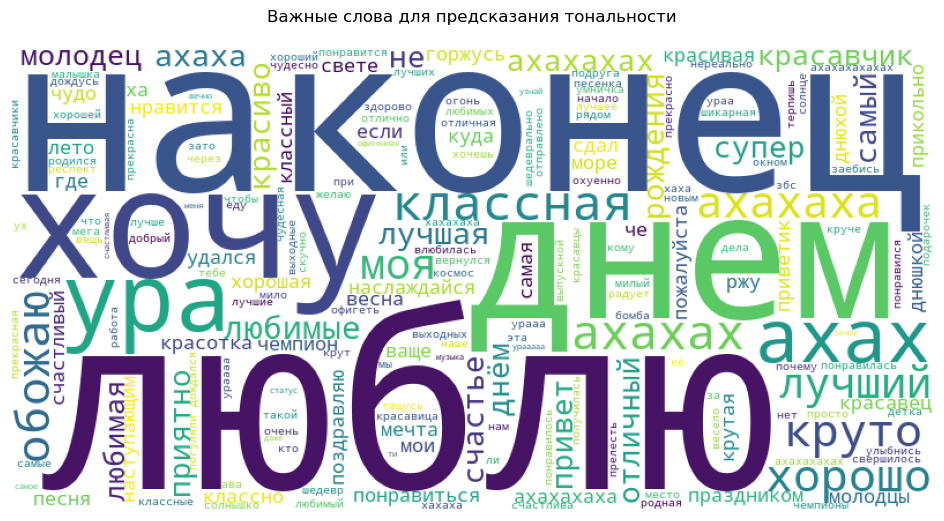

In [11]:
# Вариант 1: Облако слов
plt.figure(figsize=(12, 6))
wordcloud = WordCloud(width=800, height=400, background_color='white')
wordcloud.generate_from_frequencies(word_weights)
plt.imshow(wordcloud)
plt.axis('off')
plt.title('Важные слова для предсказания тональности', pad=20)
plt.show()

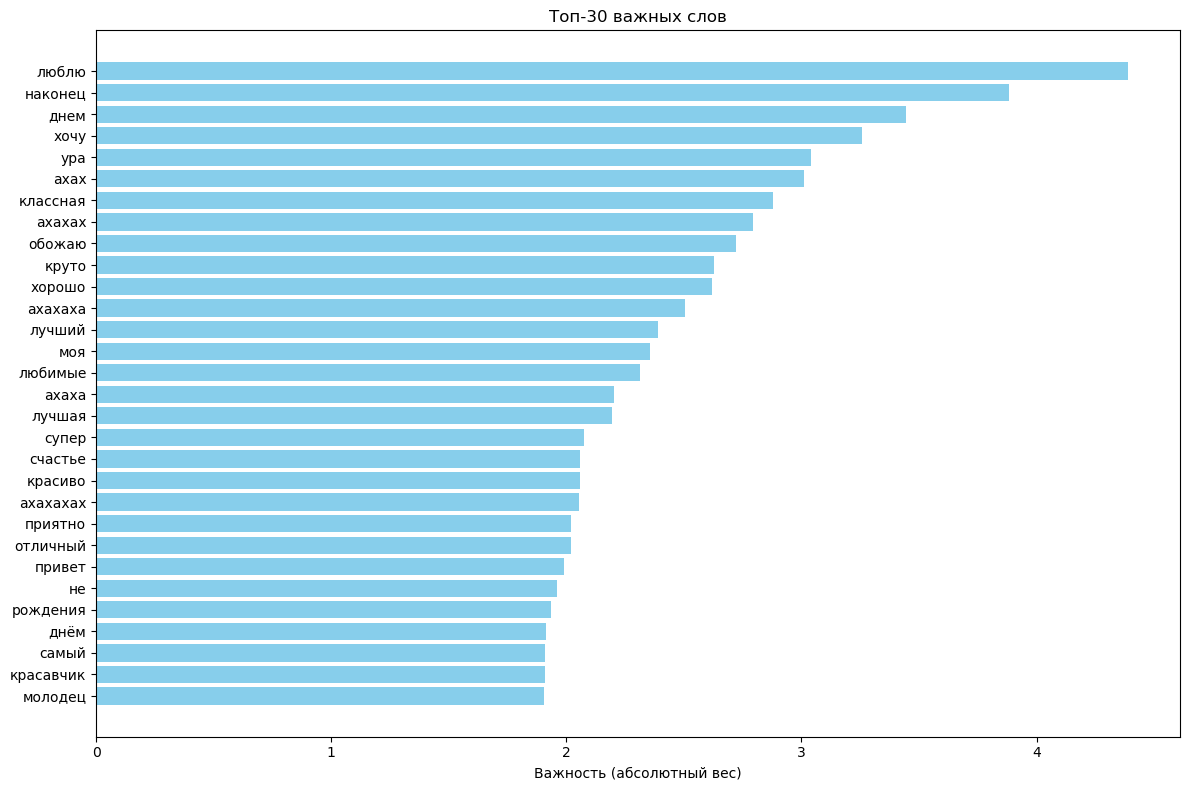

In [12]:
# Вариант 2: Барплот
plt.figure(figsize=(12, 8))
words = [w[0] for w in top_words]
importance = [w[1] for w in top_words]
plt.barh(words[::-1], importance[::-1], color='skyblue')
plt.xlabel('Важность (абсолютный вес)')
plt.title('Топ-30 важных слов')
plt.tight_layout()
plt.show()

## 2. Улучшение базовой модели за счет признаков

In [13]:
def extract_features(text):
    # Обработка случая, когда на вход подается pandas Series
    if isinstance(text, pd.Series):
        return text.apply(extract_features)
    
    # Преобразуем в строку на случай нестроковых значений
    text = str(text)
    
    # 1. Базовые метрики
    words = text.split()
    features = {
        'text_length': len(text),
        'num_words': len(words),
        'num_unique_words': len(set(words)),
        'num_uppercase': sum(1 for c in text if c.isupper()),
        'num_exclam': text.count('!'),
        'num_questions': text.count('?'),
        'num_ellipsis': text.count('...') + text.count('..'),
    }
    
    # 2. Эмоциональные маркеры
    features.update({
        'has_caps_lock': int(text.upper() == text and len(text) > 5),
        'has_letter_repeats': int(bool(re.search(r'(.)\1{2,}', text))),  # "гоооод"
        'num_emojis': len(re.findall(r'[\U0001F600-\U0001F64F\U0001F300-\U0001F5FF]', text))
    })
    
    # 3. Признаки из словаря тональностей
    sentiment = extract_sentiment_features(text) 
    features.update(sentiment)
    
    # 4. Доли слов (только если есть слова)
    if words:
        features['pct_positive'] = features.get('positive_words', 0) / len(words)
        features['pct_negative'] = features.get('negative_words', 0) / len(words)
    else:
        features['pct_positive'] = 0
        features['pct_negative'] = 0
    
    return features

In [14]:
# Применяем к данным
features_df = train_df['text'].apply(lambda x: pd.Series(extract_features(x)))
features_df

,text_length,num_words,num_unique_words,num_uppercase,num_exclam,num_questions,num_ellipsis,has_caps_lock,has_letter_repeats,num_emojis,sentiment_mean,sentiment_max,sentiment_min,positive_words,negative_words,pct_positive,pct_negative
0,69.0,10.0,9.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0000,0.0
1,31.0,4.0,4.0,3.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0000,0.0
2,34.0,6.0,6.0,1.0,7.0,0.0,0.0,0.0,1.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0000,0.0
3,48.0,8.0,8.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0000,0.0
4,59.0,10.0,10.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21263,98.0,16.0,16.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.3125,5.0,0.0,1.0,0.0,0.0625,0.0
21264,22.0,3.0,3.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0000,0.0
21265,114.0,21.0,20.0,6.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0000,0.0
21266,61.0,8.0,8.0,5.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0000,0.0


In [15]:
# 6. Разделяем данные
X = train_df['text']
y = train_df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [16]:
class TextFeatureExtractor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
        
    def transform(self, X):
        features = []
        for text in X:
            text = str(text)
            words = text.split()
            row = {
                'text_length': len(text),
                'num_words': len(words),
                'num_unique_words': len(set(words)),
                'num_exclam': text.count('!'),
                'num_questions': text.count('?'),
                'num_uppercase': sum(1 for c in text if c.isupper()),
                'has_caps_lock': int(text.upper() == text and len(text) > 5),
                'num_ellipsis': text.count('...') + text.count('..'),
                'has_letter_repeats': int(bool(re.search(r'(.)\1{2,}', text))),
                'num_emojis': len(re.findall(r'[\U0001F600-\U0001F64F\U0001F300-\U0001F5FF]', text)),    
            }
            features.append(row)
        return pd.DataFrame(features)

In [17]:
# 2. Создаем пайплайн
pipeline = Pipeline([
    ('features', FeatureUnion([
        ('tfidf', TfidfVectorizer(max_features=5000)),
        ('stats', Pipeline([
            ('extractor', TextFeatureExtractor()),
            ('scaler', StandardScaler())
        ]))
    ])),
    ('classifier', LogisticRegression(max_iter=1000, class_weight='balanced'))
])

In [18]:
# 4. Обучение
pipeline.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('tfidf',
                                                 TfidfVectorizer(max_features=5000)),
                                                ('stats',
                                                 Pipeline(steps=[('extractor',
                                                                  TextFeatureExtractor()),
                                                                 ('scaler',
                                                                  StandardScaler())]))])),
                ('classifier',
                 LogisticRegression(class_weight='balanced', max_iter=1000))])

In [19]:
# 5. Предсказание
y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    negative       0.35      0.51      0.42       673
     neutral       0.68      0.61      0.64      2537
    positive       0.57      0.57      0.57      1349
        skip       0.35      0.34      0.35       967
      speech       0.87      0.88      0.88       855

    accuracy                           0.58      6381
   macro avg       0.57      0.58      0.57      6381
weighted avg       0.60      0.58      0.59      6381



Проверка размеров: TF-IDF=5000, Stats=4, Total=5010


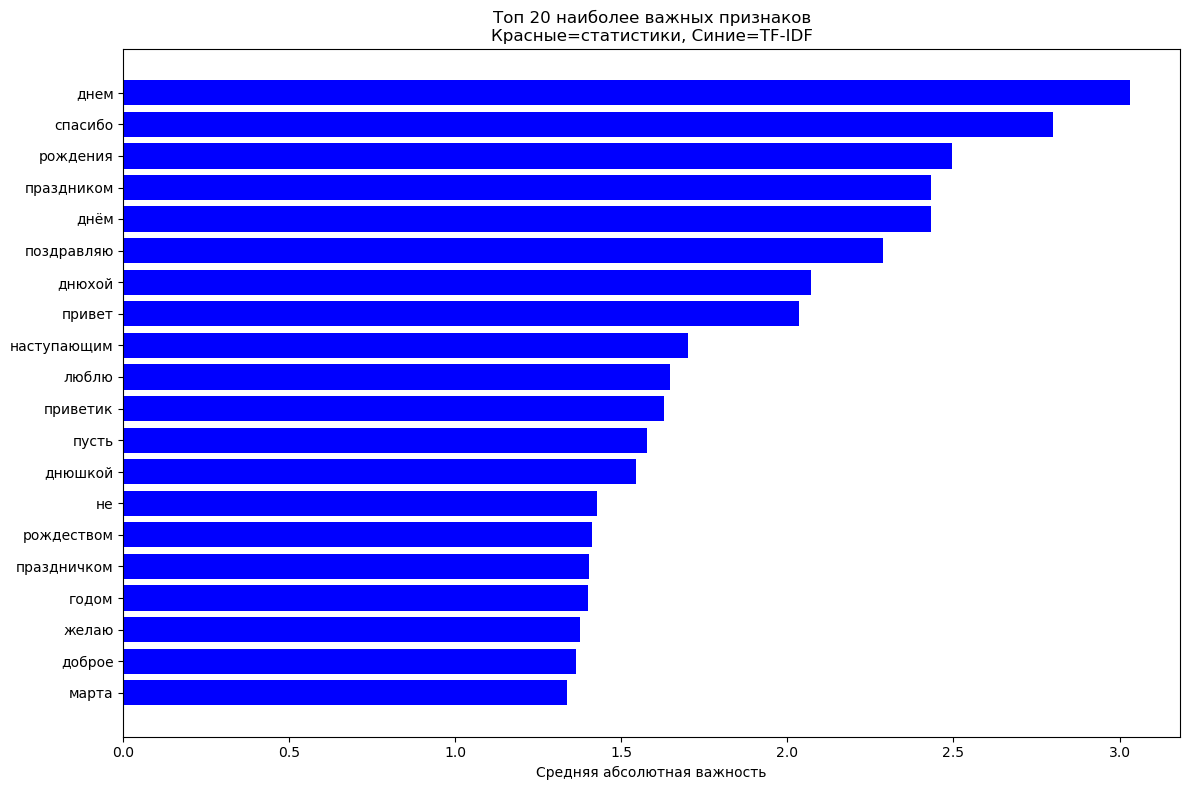

In [20]:
def get_feature_importance(pipeline, top_n=20):
    """Безопасный анализ важности признаков"""
    
    # 1. Извлекаем компоненты пайплайна
    tfidf = pipeline.named_steps['features'].transformer_list[0][1]
    stats_transformer = pipeline.named_steps['features'].transformer_list[1][1]
    model = pipeline.named_steps['classifier']
    
    # 2. Получаем названия признаков
    tfidf_features = tfidf.get_feature_names_out().tolist()
    stats_features = ['text_length', 'num_words', 'num_exclam', 'num_uppercase']
    
    # 3. Получаем веса модели
    weights = model.coef_
    
    # 4. Проверяем размерности
    n_total_features = weights.shape[1]
    n_tfidf = len(tfidf_features)
    n_stats = len(stats_features)
    
    print(f"Проверка размеров: TF-IDF={n_tfidf}, Stats={n_stats}, Total={n_total_features}")
    
    # 5. Создаем списки для DataFrame
    features = []
    importances = []
    types = []
    
    # Добавляем TF-IDF признаки
    for i in range(n_tfidf):
        features.append(tfidf_features[i])
        importances.append(np.mean(np.abs(weights[:, i])))
        types.append('tfidf')
    
    # Добавляем статистические признаки
    for i in range(n_stats):
        idx = n_tfidf + i
        features.append(stats_features[i])
        importances.append(np.mean(np.abs(weights[:, idx])))
        types.append('stats')
    
    # 6. Создаем DataFrame
    importance_df = pd.DataFrame({
        'feature': features,
        'importance': importances,
        'type': types
    }).sort_values('importance', ascending=False)
    
    # 7. Визуализация
    plt.figure(figsize=(12, 8))
    top_features = importance_df.head(top_n)
    
    colors = ['red' if typ == 'stats' else 'blue' for typ in top_features['type']]
    plt.barh(top_features['feature'][::-1], top_features['importance'][::-1], color=colors[::-1])
    plt.xlabel('Средняя абсолютная важность')
    plt.title(f'Топ {top_n} наиболее важных признаков\nКрасные=статистики, Синие=TF-IDF')
    plt.tight_layout()
    plt.show()
    
    return importance_df

# Использование
feature_importance = get_feature_importance(pipeline)

In [21]:
def plot_classification_report(y_true, y_pred):
    report = classification_report(y_true, y_pred, output_dict=True)
    df_report = pd.DataFrame(report).transpose()
    df_report.drop(columns=['support'], inplace=True)
    
    plt.figure(figsize=(10, 6))
    sns.heatmap(df_report, annot=True, cmap='Blues', fmt='.2f')
    plt.title('Classification Report')
    plt.show()

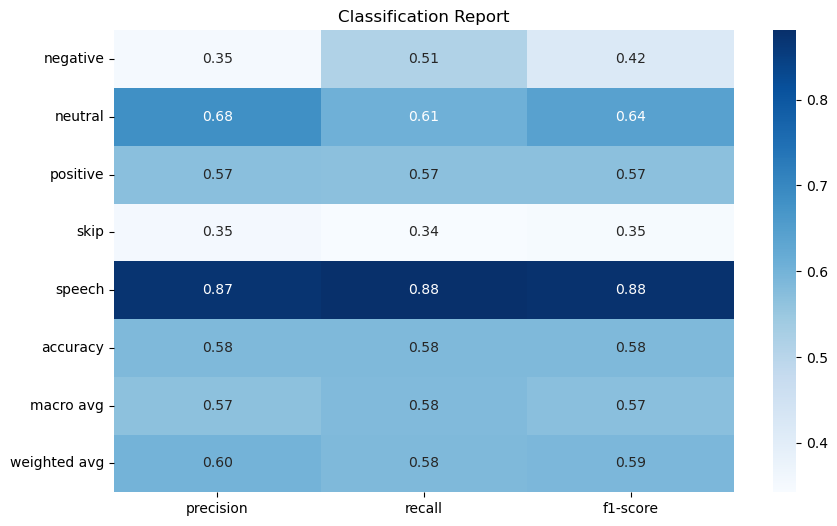

In [22]:
plot_classification_report(y_test, y_pred)

## 3. Сравнение лемм и подтокенов

In [23]:
X_train

13185    всем моим поступкам есть только одно объяснени...
17860    Желаю больше ярких дней,\nЧтобы от счастья бил...
17527                                       я люблю тебя!)
533      Каждый день радуюсь тому, что я женщина! Поздр...
15453    СЛАБО! 8 ФРАГОВ, 11 МЕДАЛЕЙ, 16 763 СЕРЕБРА, 2...
                               ...                        
11284                                     Авиашоу 9-го Мая
11964    Защитники мои, святые образа…\nНебесных сил бе...
5390                А эшелон уходит на запад,в Сталинград!
860                       У мене родилась доця 3600, 55см.
15795                     Скоро во всех кинотеатрах страны
Name: text, Length: 14887, dtype: object

In [24]:
# Лемматизация с pymorphy3
morph = pymorphy3.MorphAnalyzer()

def lemmatize(text):
    return ' '.join([morph.parse(word)[0].normal_form for word in text.split()])

In [25]:
# Токенизация с BERT
tokenizer = AutoTokenizer.from_pretrained("DeepPavlov/rubert-base-cased")

def bert_tokenize(text):
    return ' '.join(tokenizer.tokenize(text))

In [26]:
# Сравнение подходов
train_df['lemmas'] = train_df['text'].apply(lemmatize)
train_df['subwords'] = train_df['text'].apply(bert_tokenize)

In [27]:
# Леммы
vectorizer = TfidfVectorizer(max_features=10000)
X_lemma = vectorizer.fit_transform(train_df['lemmas'])
model = LogisticRegression(max_iter=1000).fit(X_lemma, train_df['label'])
y_lemma_pred = model.predict(vectorizer.transform(test_df['text'].apply(lemmatize)))

In [28]:
# Подтокены
vectorizer = TfidfVectorizer(max_features=10000, token_pattern=r'\S+')
X_sub = vectorizer.fit_transform(train_df['subwords'])
model = LogisticRegression(max_iter=1000).fit(X_sub, train_df['label'])
y_sub_pred = model.predict(vectorizer.transform(test_df['text'].apply(bert_tokenize)))


In [29]:
print("F1 леммы:", f1_score(test_df['label'], y_lemma_pred, average='macro'))
print("F1 подтокены:", f1_score(test_df['label'], y_sub_pred, average='macro'))

F1 леммы: 0.5782375892156558
F1 подтокены: 0.6372907821269932


## 4. FastText классификатор

In [30]:
train_df['text']

0        А попа подозревала давно,что ты с кавказа..пер...
1                          З прошедшим Днем Ангела))))))))
2                       Два дня до отлёта с острова!!!!!!!
3         Блин, почему эта жизнь столь не справедлива ((((
4        где еще встречать свой день рождения как не на...
                               ...                        
21263    Анастасия, у меня есть друг, с которым вы хоро...
21264                               Колька пошли гулять!!?
21265    Ура! Золото дают бесплатно!Напиши это в 4 комм...
21266    С Праздником, Ксюнь! \nЖенского счастья тебе!\...
21267    XXV МЕЖДУНАРОДНЫЙ МАРАФОН "ЭРГО - БЕЛЫЕ НОЧИ"....
Name: text, Length: 21268, dtype: object

In [31]:
def prepare_fasttext_data(df, filename):
    with open(filename, 'w', encoding='utf-8') as f:  # Явно указываем кодировку UTF-8
        for _, row in df.iterrows():
            f.write(f"__label__{row['label']} {row['text']}\n")


prepare_fasttext_data(train_df, 'train_ft.txt')
prepare_fasttext_data(test_df, 'test_ft.txt')

In [32]:
# Модель с нуля
model_scratch = fasttext.train_supervised(
    input='train_ft.txt',
    epoch=25,
    lr=1.0,
    wordNgrams=2,
    dim=300
)

In [33]:
ft_model = fasttext.load_model('cc.ru.300.bin/cc.ru.300.bin')

In [34]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [35]:
class FastTextVectorizer(BaseEstimator, TransformerMixin):
    def __init__(self, ft_model):
        self.ft_model = ft_model
        self.dim = ft_model.get_dimension()
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return np.array([self.text_to_vector(text) for text in X])
    
    def text_to_vector(self, text):
        # Получаем вектора для каждого слова и усредняем
        words = text.split()
        word_vectors = [self.ft_model.get_word_vector(w) for w in words if w in self.ft_model]
        if len(word_vectors) == 0:
            return np.zeros(self.dim)
        return np.mean(word_vectors, axis=0)

In [36]:
# Альтернативный классификатор
fasttext_clf_v2 = Pipeline([
    ('vectorizer', FastTextVectorizer(ft_model)),
    ('classifier', RandomForestClassifier())
])

# Подбор параметров
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [None, 10, 20]
}

grid_search = GridSearchCV(fasttext_clf_v2, param_grid, cv=3, n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Лучшие параметры:", grid_search.best_params_)
print("Лучшая точность:", grid_search.best_score_)

TypeError: cannot pickle 'fasttext_pybind.fasttext' object

In [37]:
from sklearn.utils import parallel_backend

In [38]:
# Создаем пайплайн
fasttext_clf = Pipeline([
    ('vectorizer', FastTextVectorizer(ft_model)),
    ('classifier', LogisticRegression(max_iter=10, class_weight='balanced'))
])

In [39]:
# С явным отображением прогресса
with parallel_backend('threading', n_jobs=1):  # Для последовательного выполнения
    fasttext_clf.fit(X_train, y_train)

C:\Soft\Anaconda\Lib\site-packages\sklearn\utils\deprecation.py:66: FutureWarning: Class parallel_backend is deprecated; deprecated in 1.5 to be removed in 1.7. Use joblib.{} instead.
  warnings.warn(msg, category=FutureWarning)
C:\Soft\Anaconda\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
y_pred = fasttext_clf.predict(X_test)
print(classification_report(y_test, y_pred))

In [201]:
# Модель с предобученными векторами
if not os.path.exists('cc.ru.300.bin.gz'):
    !wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.ru.300.bin.gz

model_pretrained = fasttext.train_supervised(
    input='train_ft.txt',
    epoch=25,
    lr=1.0,
    wordNgrams=2,
    dim=ft_model.get_dimension(),
    # pretrainedVectors='cc.ru.300.bin.gz'
    pretrainedVectors=ft_model
)

ValueError: Dimension of pretrained vectors (696835298505) does not match dimension (300)!

In [33]:
# Оценка
def evaluate_fasttext(model, test_file):
    result = model.test(test_file)
    print(f"Precision: {result[1]}, Recall: {result[2]}, F1: {2*result[1]*result[2]/(result[1]+result[2])}")

In [34]:
print("Модель с нуля:")
evaluate_fasttext(model_scratch, 'test_ft.txt')

Модель с нуля:
Precision: 0.5709470845972363, Recall: 0.5709470845972363, F1: 0.5709470845972363


In [ ]:
print("\nМодель с предобученными векторами:")
evaluate_fasttext(model_pretrained, 'test_ft.txt')

In [ ]:
# Функция для визуализации результатов FastText
def plot_fasttext_results(scratch_results, pretrained_results):
    metrics = ['Precision', 'Recall', 'F1']
    scratch_scores = [scratch_results[1], scratch_results[2], 
                    2*scratch_results[1]*scratch_results[2]/(scratch_results[1]+scratch_results[2])]
    pretrained_scores = [pretrained_results[1], pretrained_results[2], 
                       2*pretrained_results[1]*pretrained_results[2]/(pretrained_results[1]+pretrained_results[2])]
    
    x = np.arange(len(metrics))
    width = 0.35
    
    fig, ax = plt.subplots(figsize=(10, 6))
    rects1 = ax.bar(x - width/2, scratch_scores, width, label='From Scratch')
    rects2 = ax.bar(x + width/2, pretrained_scores, width, label='Pretrained')
    
    ax.set_ylabel('Scores')
    ax.set_title('FastText Model Comparison')
    ax.set_xticks(x)
    ax.set_xticklabels(metrics)
    ax.legend()
    ax.set_ylim(0, 1)
    
    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:.3f}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom')
    
    autolabel(rects1)
    autolabel(rects2)
    
    fig.tight_layout()
    plt.show()


In [ ]:
# Получаем результаты
scratch_results = model_scratch.test('test_ft.txt')
pretrained_results = model_pretrained.test('test_ft.txt')

# Визуализируем
plot_fasttext_results(scratch_results, pretrained_results)

In [ ]:
#  примеры предсказаний
def show_examples(model, n=5):
    with open('test_ft.txt', 'r') as f:
        lines = [line.strip() for line in f.readlines()[:n]]
    
    for line in lines:
        true_label = line.split()[0]
        text = ' '.join(line.split()[1:])
        pred_label = model.predict(text)[0][0]
        print(f"Text: {text}")
        print(f"True: {true_label}, Predicted: {pred_label}")
        print("-"*50)

show_examples(model_pretrained)